# An End-to-End Analytic Project Guide
## Using DSS to solve data science questions 

***
What this tutorial covers:

An example of what the Data Science Studio (DSS) framework offers the data scientist at Nielsen. This tutorial is in four parts.  This page is Part 2.

#### [Part 1 - Using Python and the Jupyter Notebook](./end-to-end-analytic-project-guide.ipynb)
<span style="color:gray">

- Spinning up a spark session
- Pulling data
- Using the DSS datacache and spark caching
- Exploring the data
- Creating a model
- Getting coefficients and graphs
</span>

#### Part 2 - Modifying the notebook into testable functions
- Changing cells into functions
- testing in the notebook

#### Part 3 - [Creating a recipe and running it in DSS's Airflow environment](./end-to-end-analytic-project-guide_part3.ipynb)
<span style="color:gray">

- Copy and modify the skeleton
- Put code and tests in the right place
- Setting up a recipe taste (metadata, job_request, and the recipe client)
- Creating the job_request and kicking off a run in Airflow
- Checking the run in the Airflow User Interface
- Checking the Spark logs
</span>

#### Part 4 - [Recipe Publishing](./end-to-end-analytic-project-guide_part4.ipynb)
<span style="color:gray">

- Preparing the recipe for publishing
    - testing
    - team review
- Using published recipes
    - running published recipes as a stand-alone recipe
    - running published recipes on a schedule
    - running published recipes as part of another recipe
</span>
    
***    

# Part 2 - Modifying the notebook into testable functions

[Part 1](./end-to-end-analytic-project-guide.ipynb) of this guide showed how we can use the notebook to do an analysis of a dataset.

Once you have an analysis process you are happy with in a notebook you are ready to transform the notebook code into functions that be run in a batch process.  How you structure code in a notebook as you are writing it is loose and not necessarily efficient. 

### Why the notebook is not a process model

A notebook is great for interactive, exploratory data analysis.  It is also not bad as a code development environment, which is what this part of the current guide is about. Notebooks are not good as a process model which is why we have to go through a process to change an analysis that works in a notebook into an analysis that runs in DSS.

A process model should handle errors, allowing you to specify what to do when something fails.  A notebook allows you to skip around and execute cells out of the order in which they appear.  This can create subtle bugs that are hard to find when the interactive execution order puts something into the notebook's environment before it is used by a cell that appears earlier in the notebook.  On the other hand a process model allows you to specify when parts of the code do not depend on other parts. How data is shared and modified by different parts of the process is implicit in a notebook but needs to be considered explicitly if you are going to have a robust and repeatable analysis process.

When we go to the cloud, we have additional aspects to consider:
- What do we do when a single node of a multi-node process goes down?  
- How do we handle file and memory access when the processes which are doing the work may be running on different processors?
- A notebook spark session grabs resources and holds them, waiting on user input.  This is inefficient.

A notebook has no mechanism for handling questions like these.

The answer that DSS allows is to modify our notebook code into functions, test those functions, and then use the functions to create separable tasks.  The tasks and the ordering dependencies between them are explicitly written as a DAG using  the syntax of Python and the Airflow task execution package.

Going through the steps to transform your notebook code into functions, and supporting the testing of your functions, is a strength of DSS.  A key part of software development is developing code that can be tested, with well defined inputs and outputs. A notebook cell is neither testable nor well defined.  Taking a working notebook analysis and recasting it as a series of functions is generally not hard.  Writing tests for these functions will help you make sure that when run as a batch job your functions will be robust.


### Imports

In a notebook you can import functions anywhere you need them and it is not uncommon to have import statements scattered through the notebook.  While Python syntax will allow you to import anywhere a statement is allowed this is not good practice.  So the first thing you need to do is go through your notebook, find all the imports, check that they are used, and move them to a cell at the top of the notebook.  You can use your browser's search-in-page function to find these. You may have imports that are in your notebook but the code that used the function is no longer used or was just present to be used to look at the data.  For instance the notebook code we used in Part 1 to create a graph will not be part of our batch process so we do not need to import matplotlib or pandas.  In another spot we imported the pyspark.sql.functions package but ended up not needing any of the functions from that package.

There is a Python standard order to how the imports should be done:
- First, specify imports from the standard library.  In the code below there are the re, sys, functools, operator, textwrap and collections standard modules being imported. 
- Next, specify imports from downloaded modules.  In this code we are importing two functions from pyspark.
- Next, import locally developed modules. In this example we import from the DSS libraries.
- If we had modules defined as part of our code they would be last.

In [1]:
# import from the python standard library
import re
import sys
from functools import reduce
import operator
import textwrap
import collections
from datetime import date

# imports from downloaded packages
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# imports from local modules
from dss_datacache_client import client
from dss_airflow_utils.hooks import SparkHook
from dss_airflow_utils.workspace_utils import path_in_workspace

[2019-03-08 20:29:12,873] {settings.py:174} INFO - settings.configure_orm(): Using pool settings. pool_size=5, pool_recycle=1800, pid=712


### Spark in the notebook and in a DAG

In a batch process you have one or more tasks connected together in a Directed Acyclic Graph (DAG).  The DAG is run by an instance of Airflow, a DAG scheduling system, which is running in Nielsen's DSS cloud account.  Setting up Spark for use in a notebook must be done explicitly.  In the DAG setting up Spark is done for you before your first task that calls upon spark's services. In preparing your notebook to be a DAG your should move all your code that sets up spark to a cell that just handles spark.

Compare this function to the one in the previous notebook.  We have moved the creation of the spark hook and session into a function.  The spark connection ID is passed in now, instead of being hard coded in the call.  This will make it easier to use the same code in other notebooks that may need to set up connections to other data sources.  When you don't have to write the same lines of code multiple times you can trust your code better and work at a higher level.

In [2]:
# spark builder function
def builder_func(builder):
    builder.appName('demo_notebook')
    builder.config('spark.dynamicAllocation.maxExecutors', '3')
    builder.config('spark.executor.memory', '4G')
    builder.config('spark.executor.cores', '2')
    builder.config('spark.driver.memory', '4G')
    builder.config('spark.driver.maxResultSize', '4G')
    
def create_spark_context(conn_id, builder_func):
    # execution of the next line creates the spark session
    spark_hook = SparkHook(conn_id=conn_id, builder_func=builder_func)
    spark = spark_hook.get_spark_session()
    return spark_hook, spark


Now we want a function to create the SQL rather than having it created by a raw notebook cell.  We created the SQL with placeholders for variables.  Now we convert this code into a dictionary definition. And we convert the SQL definition to a function and pass in the dictionary.  This is in preparation for the DAG where we will define the variable values in a file that we will use to kick off the Airflow run.

In standard SQL you can have "prepared statements" which are SQL statements that have been parsed and just lack the variables being supplied. This helps prevent SQL parsing errors and 'SQL injection' attacks. Spark SQL does not currently have a way to supply variables to SQL statements other than substituting them into a string.  This means that someone using our code in the future could specify values that break the system by creating an SQL statement that is not correct or even tries to access or manipulate data that it is not allowed to be accessed or manipulated.  To handle this we need a function that will validate the inputs to be something we expect.  The acceptable values may be very limited (e.g., there are not many databases that can be correctly substituted into the string so we check that for those database names), or the conditions may be very broad (e.g., a mkt_id is acceptable if it is a series of digits).

The next cell creates two functions.  `create_validations()` is a function specific to this particular query.  The `check_inputs()` function takes the dictionary of input keys and values that we want to apply to the string and
checks them against the validations.  So we have an example of a generic function (`check_inputs()`) and a function specific to this application (`create_validations()`). This is a good software engineering practice, to separate the code into specific and general functions.


In [3]:
def create_validations():
    """ This function gathers together the validations for this
        SQL query. 
    """
    # define functions that check that a regular expression matches
    # and give them readable names
    is_iso_date = lambda v: bool(re.match('^20\d\d-\d\d-\d\d$', str(v)))
    is_str = lambda v: bool(re.match('^[^"\'"]+$', str(v)))  # quotes not allowed
    is_list_int = (lambda v: isinstance(v, list) and
                          reduce(operator.__and__, 
                                 [isinstance(e, int) for e in v]))    
    # return a dictionary with keys being the substitution fields
    # and values being a boolean function to apply
    return {
        'sales_database': lambda v: v in ['aod_pg_prototxi_02', 'aod_pg_prototxi_13'],
        'channel': is_str,
        'banner': is_str,
        'product_keys': is_list_int,
        'catg': is_str,
    }


def check_inputs(inputs, validations):
    """ A generic function to check if fields in the inputs dict match
        patterns specified in the validations dictionary.
    """
    # keys that are not in validations are assumed to not be in the
    # string to be formatted and therefore OK since they are not used.
    # so we set up a defaultdict with returns True if key not present.
    patterns = collections.defaultdict(lambda v: True, validations)
    # check that inputs is a dictionary
    if not isinstance(inputs, dict):
        return False, "inputs variable is not a dictionary"
    # check that values match patterns
    if reduce(operator.__and__, [patterns[key](inputs[key]) for key in inputs]):
        return True, ""
    # Something didn't match, create an informative error message
    msgs = []
    for key in inputs:
        if not patterns[key](inputs[key]):
            msgs.append('{key} does not match expected pattern, got {val}'
                        .format(key=key, val=inputs[key]))
    return False, '\n'.join(msgs)


The following function is brought over from the previous notebook with no changes.  It translates a string representing a date into a Python `date`.

In [4]:
def date_fromisoformat(date_str):
    """ Cover difference between Python 2 and Python 3."""
    if sys.version[0] == 3:
        return date.fromisoformat(date_str)
    else:
        return date(*[int(p) for p in date_str.split('-')])

Now that we have defined the functions above we want to test them.  Because we have small functions that have specific responsibilities, it is easy to write a simple test and run it in a notebook cell.  The following cell asserts that the return from check_inputs is True.  Note that since check_inputs really returns a tuple of boolean plus error message we have to assert only the first value in the tuple, thus the '[0]' in the call to assert.  `assert()` doesn't return anything if the value is true, so we don't expect any output for the cell below.

In [5]:
inputs = {
    'sales_database': 'aod_pg_prototxi_02',
    'catg': 'LAUNDRY CARE',
    'channel': 'Grocery - Supermarket-Conventional',
    'banner': 'Albertsons',
    'product_keys': [ 72295087 ]
}

assert(check_inputs(inputs, create_validations())[0])

Now we define another function that is specific to this analysis.  This one takes in the dictionary of inputs to substitute and returns the SQL that we want as our query. 

You can see here why we used the `textwrap.dedent()` function.  This Python library function takes a multiline string and removes the maximum common amount of whitespace from each line.  So we can move the entire string over to make it fit nicely in our function without worrying that the movement will cause it to not be found in the datacache.

Finally, to check that everything is defined properly we execute the function and print the SQL that is returned.

In [6]:
def create_query(inputs):
    valid_inputs, msg = check_inputs(inputs, create_validations())
    if not valid_inputs: # if the inputs do not pass scrutiny go no further
        raise ValueError(msg)
    sql = textwrap.dedent("""\
        select a.*, 
               case 
                  when promo_pri_index < 0.95 then 1 
                  else 0 
               end as tpr /* indicator of a price reduction greater than 5% */
        from 
        (select str.nielsen_scantrack_mkt_code as Scantrack_Code,
               str.nielsen_scantrack_mkt_name as Scantrack_Market, 
               str.store_name as Banner,
               str.pod_id,
               to_date(substring(fct.period_description_short,
                          length(fct.period_description_short)-8, 9), 'MM/dd/yy') as period,
               fct.product_key,
               fct.units,
               fct.dol,
               fct.base_units,
               fct.base_dol,
               (fct.dol / fct.units) as act_pri_uni,             /* actual price per unit */
               (fct.Base_DOL / fct.Base_Units) as base_pri_uni,  /* base price per unit */
               case
                  when (fct.dol / fct.units) / (fct.Base_DOL / fct.Base_Units)  > 1.0 then 1.0
                  else (fct.dol / fct.units) / (fct.Base_DOL / fct.Base_Units)
               end as promo_pri_index  /* in case had problems with round() function */
        from {db}.str
        inner join {db}.fct
           on fct.pod_id = str.pod_id
        inner join {db}.prdc
           on prdc.product_key = fct.product_key
        where str.channel like '%{channel}%'
          and str.store_name = '{banner}'
          and str.nielsen_scantrack_mkt_code not like '%NOT APPLICABLE%'
          and prdc.pg_category like '%{category}%'
          and ({products})
          and fct.units > 0
          and fct.dol > 0
          and fct.base_units > 0
          and fct.base_dol > 0
          and (fct.dol / fct.units) > 0.10  /* restrict to reasonable prices */
          ) as a
        """).format(db = inputs['sales_database'],
                    channel = inputs['channel'],
                    banner = inputs['banner'],
                    category = inputs['catg'],
                    products = ' OR '.join(["fct.product_key = {}".format(p) 
                                            for p in inputs['product_keys']])
                   )
    return sql

print(create_query(inputs))

select a.*, 
       case 
          when promo_pri_index < 0.95 then 1 
          else 0 
       end as tpr /* indicator of a price reduction greater than 5% */
from 
(select str.nielsen_scantrack_mkt_code as Scantrack_Code,
       str.nielsen_scantrack_mkt_name as Scantrack_Market, 
       str.store_name as Banner,
       str.pod_id,
       to_date(substring(fct.period_description_short,
                  length(fct.period_description_short)-8, 9), 'MM/dd/yy') as period,
       fct.product_key,
       fct.units,
       fct.dol,
       fct.base_units,
       fct.base_dol,
       (fct.dol / fct.units) as act_pri_uni,             /* actual price per unit */
       (fct.Base_DOL / fct.Base_Units) as base_pri_uni,  /* base price per unit */
       case
          when (fct.dol / fct.units) / (fct.Base_DOL / fct.Base_Units)  > 1.0 then 1.0
          else (fct.dol / fct.units) / (fct.Base_DOL / fct.Base_Units)
       end as promo_pri_index  /* in case had problems with round() function */
fro

Now we have a function to start our spark session and one to create the SQL we will use when we call the datacache client to go get the data.  

In our notebook we queried the datacache, retrieved the data as a Spark dataframe, cached the resulting dataframe and ran our analysis on it.  This was done in a series of notebook cells and included looks at the data to be sure that we were getting the right stuff.  Now we define a function that will do all the work of getting the dataframe ready for us to use in running analyses.

For our quick development test we execute the function and then check that we got back the expected number of rows.  Since we are pulling from a cache it should execute in a minute or so and retrieve exactly what was retrieved when we were building the analysis.

Note that this is not a definitive test.  It is more a development kind of thing to be sure that we haven't modified the query string resulting in it not being found in the cache.  In a running system you need to be sure that someone hasn't pulled the data again, resulting in a different version being the 'latest' version. If you want to pull the same dataset from the cache on two different calls, DSS allows you to get a version id from the metadata returned with your first `get()` and then use that version id in your later retrievals.

You can see here that we are building up the functionality a piece at a time so that we can check that we have a good base to work from before we proceed to the next development task.

In [7]:
def get_dataframe(sql, spark_hook, spark):
    CACHE_ONLY = {"type": "range", "to": "latest_cached"}
    meta_data = client.get(query=sql, hook=spark_hook,  tolerance=CACHE_ONLY)
    sdf = meta_data.to_spark(spark)
    sdf.cache()
    return sdf

spark_hook, spark = create_spark_context("metastore_ndx_uat_adls", builder_func)
sdf = get_dataframe(create_query(inputs), spark_hook, spark)

print(sdf.count()) # should print 452


[2019-03-08 20:29:13,978] {base_hook.py:83} INFO - Using connection to: dssadlsdemocs.azuredatalakestore.net
[2019-03-08 20:29:13,982] {base_hook.py:83} INFO - Using connection to: hiveservice
[2019-03-08 20:29:13,987] {base_hook.py:83} INFO - Using connection to: dssadlsdemocs.azuredatalakestore.net
[2019-03-08 20:29:13,990] {base_hook.py:83} INFO - Using connection to: dssadlsdemocs.azuredatalakestore.net
[2019-03-08 20:29:24,163] {log.py:114} INFO - 9a6a2577-ba10-4ff6-9c4f-23fa1c41105d - TokenRequest:Getting token with client credentials.
[2019-03-08 20:29:24,328] {log.py:114} INFO - 9a6a2577-ba10-4ff6-9c4f-23fa1c41105d - OAuth2Client:Get Token Server returned this correlation_id: 9a6a2577-ba10-4ff6-9c4f-23fa1c41105d
[2019-03-08 20:29:24,378] {api.py:107} INFO - Query select a.*, 
       case 
          when promo_pri_index < 0.95 then 1 
          else 0 
       end as tpr /* indicator of a price reduction greater than 5% */
from 
(select str.nielsen_scantrack_mkt_code as Scantrack

In [8]:
def compute_means(sdf, spark):
    sdf.registerTempTable('tbl')

    # log our units and price variables 
    # compute interaction variable
    # also drop outliers we identified in exploratory analyses (not shown here)
    nsdf0 = spark.sql("""
      select *,
        log(units) as ln_units,
        log(act_pri_uni) as ln_price,
        log(base_pri_uni) as ln_base_price,
        log(promo_pri_index) as ln_ppi,
        log(act_pri_uni) * tpr as ln_price_tpr
      from tbl
      where act_pri_uni >= 2.25 /* one record at 99 cents, one at $2.23, rest $3.00+ */
        and units < 95          /* one very high outlier */
    """)
    nsdf0.createOrReplaceTempView('nsdf_v')
    
    sql = textwrap.dedent("""\
    select pod_id,
           mean(ln_units)      as avg_ln_units,
           mean(ln_price)      as avg_ln_price,
           mean(ln_base_price) as avg_ln_base_price,
           mean(ln_ppi)        as avg_ln_ppi,
           mean(tpr)           as avg_tpr,
           mean(ln_price_tpr)  as avg_ln_price_tpr
           from nsdf_v 
           group by pod_id
    """)
    nsdf_means = spark.sql(sql)
    nsdf_means.createOrReplaceTempView('nsdf_means_v')

    # subtract the means
    sql = textwrap.dedent("""\
    select a.Scantrack_Code, a.Scantrack_Market, a.Banner, a.pod_id, a.period, a.product_key,
           a.units, a.dol, a.base_units, a.base_dol, a.act_pri_uni, a.base_pri_uni,
           a.promo_pri_index, a.tpr,
           (a.ln_units - b.avg_ln_units) as ln_units_c,
           (a.ln_price - b.avg_ln_price) as ln_price_c,
           (a.ln_base_price - b.avg_ln_base_price) as ln_base_price_c,
           (a.ln_ppi - b.avg_ln_ppi) as ln_ppi_c,
           (a.tpr - b.avg_tpr) as tpr_c,
           (a.ln_price_tpr - b.avg_ln_price_tpr) as ln_price_tpr_c
    from nsdf_v as a
    left join nsdf_means_v as b
       on b.pod_id = a.pod_id
    """)

    return spark.sql(sql)

sdf = compute_means(get_dataframe(create_query(inputs), spark_hook, spark), spark)


[2019-03-08 20:29:46,299] {log.py:114} INFO - ee7657bf-c2b7-4ae6-a1a6-c75a10d41016 - TokenRequest:Getting token with client credentials.
[2019-03-08 20:29:46,437] {log.py:114} INFO - ee7657bf-c2b7-4ae6-a1a6-c75a10d41016 - OAuth2Client:Get Token Server returned this correlation_id: ee7657bf-c2b7-4ae6-a1a6-c75a10d41016
[2019-03-08 20:29:46,700] {api.py:107} INFO - Query select a.*, 
       case 
          when promo_pri_index < 0.95 then 1 
          else 0 
       end as tpr /* indicator of a price reduction greater than 5% */
from 
(select str.nielsen_scantrack_mkt_code as Scantrack_Code,
       str.nielsen_scantrack_mkt_name as Scantrack_Market, 
       str.store_name as Banner,
       str.pod_id,
       to_date(substring(fct.period_description_short,
                  length(fct.period_description_short)-8, 9), 'MM/dd/yy') as period,
       fct.product_key,
       fct.units,
       fct.dol,
       fct.base_units,
       fct.base_dol,
       (fct.dol / fct.units) as act_pri_uni,      

In this simple example we are just doing a straight-forward analysis.  We can express the whole thing in a single function, and report the results by writing to a stream we will pass in.  For testing that stream will be our notebook's standard output but we write it so that when we run this in the cloud we can pass in an open file and output will go to the file instead of the standard out.

For later analysis we will return the dataframe of predictions.

In [9]:
def do_analysis(sdf, spark, outstream):
    nsdf = compute_means(sdf, spark)

    my_predictors = ['ln_price_c', 'tpr_c', 'ln_price_tpr_c']

    vectorAssembler = VectorAssembler(inputCols = my_predictors, outputCol = 'features')
    va_nsdf = vectorAssembler.transform(nsdf)
    va_nsdf = va_nsdf.select(['ln_units_c', 'features', 'pod_id', 'period', 'tpr', 'Scantrack_Market'])

    lr = LinearRegression(featuresCol = 'features',
                          labelCol='ln_units_c', 
                          maxIter=150, 
                          regParam=0.0, 
                          elasticNetParam=0.0,
                          fitIntercept=True
                         )
    lr_model = lr.fit(va_nsdf)

    outstream.write("           RMSE: {:f}\n".format(lr_model.summary.rootMeanSquaredError))
    outstream.write("      R-squared: {:f}\n".format(lr_model.summary.r2))

    outstream.write("Coefficients for {}\n".format(my_predictors))
    outstream.write("   Coefficients: [{}]\n".format(', '.join(['{:f}'.format(c) for c in lr_model.coefficients])))
    outstream.write("      Intercept: {:f}\n".format(lr_model.intercept))
    
    return lr_model.summary.predictions, lr_model.summary.residuals

Here is the call to test the function above, writing the output to the standard output.  This is a good way to do a quick check but it is not the way we should run in a batch process.

In [10]:
%%time

preds, resids = do_analysis(get_dataframe(create_query(inputs), spark_hook, spark), spark,
                        sys.stdout)

[2019-03-08 20:29:50,505] {log.py:114} INFO - 93cb9f2b-96e6-4229-b833-5b6b2ddaf75c - TokenRequest:Getting token with client credentials.
[2019-03-08 20:29:50,715] {log.py:114} INFO - 93cb9f2b-96e6-4229-b833-5b6b2ddaf75c - OAuth2Client:Get Token Server returned this correlation_id: 93cb9f2b-96e6-4229-b833-5b6b2ddaf75c
[2019-03-08 20:29:50,816] {api.py:107} INFO - Query select a.*, 
       case 
          when promo_pri_index < 0.95 then 1 
          else 0 
       end as tpr /* indicator of a price reduction greater than 5% */
from 
(select str.nielsen_scantrack_mkt_code as Scantrack_Code,
       str.nielsen_scantrack_mkt_name as Scantrack_Market, 
       str.store_name as Banner,
       str.pod_id,
       to_date(substring(fct.period_description_short,
                  length(fct.period_description_short)-8, 9), 'MM/dd/yy') as period,
       fct.product_key,
       fct.units,
       fct.dol,
       fct.base_units,
       fct.base_dol,
       (fct.dol / fct.units) as act_pri_uni,      

The cell below shows the API we can use (the call `path_in_workspace()`) to set up a file that will work in both the notebook and in DSS's Airflow execution environment. We close the file using Python's implicit `close()` call when the open is done with the `with` keyword.  To allow the quick check that we are getting what we expect the code block below writes out the file to standard output.

In [11]:
%%time

path_to_results = path_in_workspace('ModelResults.txt')
print("Writing results to {}".format(path_to_results))
with open(path_to_results, "w") as f:
    do_analysis(get_dataframe(create_query(inputs), spark_hook, spark), spark, f)
with open(path_to_results) as f:
    for l in f:
        print(l.rstrip())

Writing results to /tmp/ModelResults.txt
[2019-03-08 20:30:16,415] {log.py:114} INFO - 7cb10631-2717-4eca-8063-ab8778fbef19 - TokenRequest:Getting token with client credentials.
[2019-03-08 20:30:16,565] {log.py:114} INFO - 7cb10631-2717-4eca-8063-ab8778fbef19 - OAuth2Client:Get Token Server returned this correlation_id: 7cb10631-2717-4eca-8063-ab8778fbef19
[2019-03-08 20:30:16,653] {api.py:107} INFO - Query select a.*, 
       case 
          when promo_pri_index < 0.95 then 1 
          else 0 
       end as tpr /* indicator of a price reduction greater than 5% */
from 
(select str.nielsen_scantrack_mkt_code as Scantrack_Code,
       str.nielsen_scantrack_mkt_name as Scantrack_Market, 
       str.store_name as Banner,
       str.pod_id,
       to_date(substring(fct.period_description_short,
                  length(fct.period_description_short)-8, 9), 'MM/dd/yy') as period,
       fct.product_key,
       fct.units,
       fct.dol,
       fct.base_units,
       fct.base_dol,
       (f

### Debugging the functions

Sometimes, even if we are writing small, testable functions in a notebook you can come to where you need a debugger. Compared to a real IDE (Integrated Development Environment) such as Pycharm or Visual Studio, notebooks are impoverished second cousins.  But it is still possible to interactively debug within a notebook.

We just have to import the notebook's debugger with the following:
```python
import IPython.core.debugger as ipdb
```

And then, where we want to stop and examine variables, etc., we put the following line right before the line of code we want to stop at:
```python
ipdb.set_trace()
```

This gives you the standard Python command line debugger but input is from an input box in the notebook's output area. When the `set_trace()` is hit, execution is halted and you can then print out the values of variables, set additional break points, single step through a function or step into called functions.  If you get lost "w" (where) prints a stack trace and "c" (continue) resumes execution.

This tutorial is not the place for a tutorial on the Python debugger.  The [official documentation](https://docs.python.org/3/library/pdb.html#module-pdb) can be consulted, or there is an unofficial [tutorial](https://realpython.com/python-debugging-pdb/) on the web.

To show that the values computed by the functions are the same as the ones we got running cells in the notebook we can read the output file into a pandas dataframe and attempt the same plot.  We don't use pandas or matplotlib in the functions we have defined, and won't be using them in our final python program, so we need to import them here.

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

Just like in the previous page of this guide we take our predictions and residuals spark dataframes and turn them into pandas dataframes, rename a couple columns, and join them together into a single pandas dataframe.

In [13]:
p = preds['ln_units_c', 'prediction', 'pod_id', 'period', 'tpr', 'Scantrack_Market'].toPandas()
r = resids.toPandas()
# pull out predicted and observed outcome values and other variables, merge with residuals

p.rename(columns={'prediction':'predicted'}, inplace=True)
r.rename(columns={'residuals':'resid'}, inplace=True)
p_df = pd.concat([p, r], axis=1)

del(p, r)

The features vector that we did the regression on is in the form of a "DenseVector".  We pull the values out of that vector, give them column names, and add the features to our pandas dataframe.  Finally I use the display function to display the table.

In [14]:
# split out the "features" column of DenseVectors to merge these predictors with data frame above

preds.createOrReplaceTempView('p')
my_predictors = ['ln_price_c', 'tpr_c', 'ln_price_tpr_c']

t = (spark.sql("select features from p").rdd
     .map(lambda x:[float(y) for y in x['features']])
     .toDF(my_predictors)).toPandas()

# merge back in with y, y-hat, and resid
p_df = pd.concat([p_df, t], axis=1)

del(t)

display(p_df)

ln_units_c     predicted   pod_id      period  tpr      Scantrack_Market  \
0     -0.277259 -1.397984e-02   234134  2018-11-17    0  Salt Lake City-Boise   
1     -0.584906 -1.563399e-01    43911  2018-10-27    0  Salt Lake City-Boise   
2      0.215530 -5.694704e-02    10017  2018-11-17    0  Salt Lake City-Boise   
3      1.130329  9.840246e-01   181332  2018-11-03    1  Salt Lake City-Boise   
4      0.866189  1.209424e-17  5037047  2018-11-03    1               Phoenix   
5      0.139295 -8.024728e-02    10835  2018-10-27    0  Salt Lake City-Boise   
6     -0.277259 -1.397984e-02   234134  2018-12-22    0  Salt Lake City-Boise   
7      0.626381  3.306717e-16    36150  2018-11-03    1             Las Vegas   
8     -0.468213 -9.569266e-02    70203  2018-12-01    0  Salt Lake City-Boise   
9     -0.498240  7.217259e-01    10671  2018-12-08    1  Salt Lake City-Boise   
10    -0.949113 -1.474939e-01   181332  2018-12-22    0  Salt Lake City-Boise   
11     0.231049 -7.239290e-02    10566  2018-12-15    0  Salt Lake City-Boise   
12     0.419623 -1.184926e-01     8331  2018-11-10    0                Denver   
13    -0.112157 -3.064832e-16  5189772  2018-11-03    1             Las Vegas   
14    -0.732408  1.036763e-01   264078  2018-11-10    1             Las Vegas   
15     0.071921 -5.731419e-02   294950  2018-12-29    0  Salt Lake City-Boise   
16     0.765068  3.885000e-01    43912  2018-11-03    1  Salt Lake City-Boise   
17     0.000000  1.209424e-17   341654  2018-10-27    1             Las Vegas   
18    -0.198042  1.848682e-02   190785  2018-12-22    0  Salt Lake City-Boise   
19    -0.277259 -2.188759e-01     9813  2018-11-24    0  Salt Lake City-Boise   
20     0.477386 -5.731419e-02   294950  2019-01-05    0  Salt Lake City-Boise   
21    -0.553029 -1.018422e-01  5037545  2019-01-05    0  Salt Lake City-Boise   
22     0.503212 -1.863548e-01    10017  2019-01-12    0  Salt Lake City-Boise   
23    -0.740715 -6.480870e-02  1393760  2018-11-17    0  Salt Lake City-Boise   
24     1.436312  5.183814e-02  5032275  2018-11-03    1             Las Vegas   
25    -0.584906 -1.563399e-01    43911  2019-01-05    0  Salt Lake City-Boise   
26     0.415888 -3.362698e-01     9813  2019-01-12    0  Salt Lake City-Boise   
27    -0.553029 -1.018422e-01  5037545  2018-11-10    0  Salt Lake City-Boise   
28     0.809575  7.684312e-01    30264  2018-11-03    1               Spokane   
29     0.107467 -1.931236e-01   417433  2018-11-17    0  Salt Lake City-Boise   
..          ...           ...      ...         ...  ...                   ...   
419   -0.289037 -7.387223e-02    30264  2018-10-27    0               Spokane   
420   -0.388788  1.052182e+00    34187  2018-11-03    1  Salt Lake City-Boise   
421    0.419623 -1.184926e-01     8331  2018-12-01    0                Denver   
422    0.154033  4.976993e-01     8327  2018-11-03    1                Denver   
423    0.798888 -7.933664e-02    10385  2019-01-05    0  Salt Lake City-Boise   
424    1.685206  1.030738e+00    69469  2018-11-03    1  Salt Lake City-Boise   
425   -0.173287 -9.705580e-02    86098  2019-01-19    0  Salt Lake City-Boise   
426   -0.289037 -7.387223e-02    30264  2018-11-17    0               Spokane   
427   -0.376019  2.783451e-02  5030316  2018-11-03    1             Las Vegas   
428    0.138629 -8.872699e-02    10195  2018-12-29    0  Salt Lake City-Boise   
429   -0.783251 -8.420690e-02    72520  2018-12-22    0  Salt Lake City-Boise   
430    0.618292 -1.931236e-01   417433  2018-12-22    0  Salt Lake City-Boise   
431   -0.539114  1.768262e-01     8327  2019-01-19    1                Denver   
432   -0.621227 -5.731419e-02   294950  2018-10-27    0  Salt Lake City-Boise   
433    0.357897 -6.480870e-02  1393760  2018-12-29    0  Salt Lake City-Boise   
434   -0.598436 -1.089608e-01   341220  2019-01-05    0  Salt Lake City-Boise   
435   -0.468213 -2.251004e-01    70203  2019-01-12    0  Salt Lake City-Boise   
436    0.902221  1.209424e-17  40948

Here we redo the scatter plot of the residuals versus the predictions.  The plot is the same as the one produced by the notebook code, confirming our belief that the values produced by our functions are the same.

449 Observations used in the model
CPU times: user 79.1 ms, sys: 78.6 ms, total: 158 ms
Wall time: 199 ms


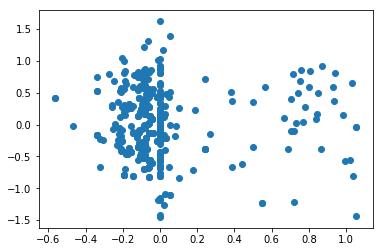

In [15]:
%%time 
print("{0} Observations used in the model".format(p_df.shape[0]))
plt.scatter(p_df.predicted, p_df.resid)  # syntax is plt.scatter(x, y)

<span style="color:red">**VERY IMPORTANT**</span>
Stop the spark session that you started from the notebook.  If you don't do this it continues to live and reserve resources that the cloud provider charges for and that are not available for others to use.

In [16]:
spark.stop()

Now we have our model in a form that we can more easily convert to a batch process, what DSS calls a "recipe".  In [part 3](./end-to-end-analytic-project-guide_part3.ipynb) of this _Analytic Project_ guide we will talk about the process of creating and testing a DSS "recipe" that can be published for other analysts to use.